# Check the label_encoder files are all the same between training runs

In [1]:
# The function below will:
# - Find all label_encoder.joblib files recursively in models
# - Load each encoder and compare their classes_ attributes
# - Print a clear report showing which encoders match and which differ
# - Return True if all are equivalent, False otherwise
import numpy as np
import os
from joblib import load
from sklearn.preprocessing import LabelEncoder

In [2]:

def compare_label_encoders():
    # Find all label_encoder.joblib files
    encoder_files = []
    for root, dirs, files in os.walk("models"):
        for file in files:
            if file == "label_encoder.joblib":
                encoder_files.append(os.path.join(root, file))

    if not encoder_files:
        print("No label_encoder.joblib files found.")
        return True

    # Load and compare each encoder
    encoders = []
    for file in encoder_files:
        encoder = load(file)
        if not isinstance(encoder, LabelEncoder):
            print(f"File {file} is not a LabelEncoder.")
            return False
        encoders.append(encoder)

    # Compare classes_ attributes
    first_classes = encoders[0].classes_
    all_equivalent = True
    for i, encoder in enumerate(encoders[1:], start=2):
        if not np.array_equal(first_classes, encoder.classes_):
            print(f"Encoder {i} differs from the first encoder.")
            all_equivalent = False

    return all_equivalent

In [3]:
compare_label_encoders()

True

# Create comprehensive comparison charts for all baseline models

In [5]:
import os, json, time, warnings
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import warnings

# RANDOM_STATE = 42
# np.random.seed(RANDOM_STATE)

## do not display DtypeWarning from Pandas
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

In [6]:
def create_comparison_visualizations(summary_df, outdir):
    """
    Create comprehensive comparison charts for all baseline models
    """
    print(f"\nGenerating comparison visualizations...")
    
    # 1. Bar chart comparing all metrics across models
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    metrics = ['Accuracy', 'F1_macro', 'Precision_macro', 'Recall_macro']
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        summary_df.plot(x='model', y=metric, kind='bar', ax=ax, legend=False, color='steelblue')
        ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
        ax.set_xlabel('Model', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.set_xticklabels(summary_df['model'], rotation=45, ha='right')
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', padding=3)
    
    plt.tight_layout()
    plt.savefig(outdir / "metrics_comparison_bars.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Radar/Spider chart for multi-metric comparison
    from math import pi
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    angles = [n / len(metrics) * 2 * pi for n in range(len(metrics))]
    angles += angles[:1]
    
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    
    for idx, row in summary_df.iterrows():
        values = row[metrics].tolist()
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=row['model'])
        ax.fill(angles, values, alpha=0.15)
    
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax.set_title('Multi-Metric Performance Comparison', size=16, fontweight='bold', pad=20)
    ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(outdir / "metrics_radar_chart.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. Heatmap of all metrics
    plt.figure(figsize=(10, 6))
    metrics_matrix = summary_df.set_index('model')[metrics]
    sns.heatmap(metrics_matrix, annot=True, fmt='.3f', cmap='YlGnBu', 
                cbar_kws={'label': 'Score'}, linewidths=0.5)
    plt.title('Performance Metrics Heatmap', fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Models', fontsize=12)
    plt.tight_layout()
    plt.savefig(outdir / "metrics_heatmap.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # 4. Model ranking visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Calculate average rank for each model
    ranks = summary_df[metrics].rank(ascending=False)
    ranks['model'] = summary_df['model']
    ranks['avg_rank'] = ranks[metrics].mean(axis=1)
    ranks = ranks.sort_values('avg_rank')
    
    x_pos = np.arange(len(ranks))
    bars = ax.barh(x_pos, ranks['avg_rank'], color='coral')
    ax.set_yticks(x_pos)
    ax.set_yticklabels(ranks['model'])
    ax.invert_yaxis()
    ax.set_xlabel('Average Rank (lower is better)', fontsize=12)
    ax.set_title('Model Ranking Based on Average Performance', fontsize=16, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, ranks['avg_rank'])):
        ax.text(val + 0.05, i, f'{val:.2f}', va='center')
    
    plt.tight_layout()
    plt.savefig(outdir / "model_ranking.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # 5. Box plot showing metric distribution
    fig, ax = plt.subplots(figsize=(12, 6))
    melted = summary_df.melt(id_vars='model', value_vars=metrics, 
                             var_name='Metric', value_name='Score')
    sns.boxplot(data=melted, x='Metric', y='Score', ax=ax, palette='Set2')
    sns.swarmplot(data=melted, x='Metric', y='Score', color='black', alpha=0.5, ax=ax)
    ax.set_title('Distribution of Metrics Across All Models', fontsize=16, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(outdir / "metrics_distribution.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"✓ Generated 5 comparison visualizations in {outdir}")
    print("  - metrics_comparison_bars.png")
    print("  - metrics_radar_chart.png")
    print("  - metrics_heatmap.png")
    print("  - model_ranking.png")
    print("  - metrics_distribution.png")

In [9]:
outdir = Path("models/baseline_comparisons_v2")
outdir.mkdir(parents=True, exist_ok=True)
summary_df = pd.read_csv("models/holdout_summary.csv")
# summary_df.drop(summary_df[summary_df['model'].str.contains("MLP")].index, inplace=True)
summary_df

,model,Accuracy,F1_macro,F1_weighted,Precision_macro,Precision_weighted,Recall_macro,Recall_weighted,training_time_sec
0,SVC_GPU,0.983935,0.751124,0.983591,0.824535,0.985091,0.734439,0.983935,3190.860011
1,XGBoost_CUDA,0.989746,0.781287,0.990526,0.764588,0.991875,0.808206,0.989746,999.000000
2,LogisticRRegression,0.975162,0.711888,0.974237,0.747405,0.974518,0.707329,0.975162,999.000000
3,KNN_GPU,0.989518,0.794595,0.989863,0.787207,0.990382,0.802869,0.989518,999.000000
4,RandomForest_GPU,0.986670,0.766923,0.988261,0.749062,0.990827,0.805920,0.986670,999.000000
5,MLP_GPU,0.990088,0.803088,0.990255,0.814559,0.990534,0.794249,0.990088,2483.340000


In [10]:
create_comparison_visualizations(summary_df, outdir)


Generating comparison visualizations...
✓ Generated 5 comparison visualizations in models\baseline_comparisons_v2
  - metrics_comparison_bars.png
  - metrics_radar_chart.png
  - metrics_heatmap.png
  - model_ranking.png
  - metrics_distribution.png


# MLP Debugging

In [3]:
pd.read_csv("models/MLP_GPU/cv_results.csv").sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__batch_size,param_model__lr,param_model__module__dropout,param_model__module__hidden_dim,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
46,453.873525,0.996176,0.428897,0.126358,64,0.001925,0.193947,64,64,"OrderedDict([('model__batch_size', 64), ('model__lr', 0.0019254152592663122), ('model__module__dropout', 0.19394695981496918), ('model__module__hidden_dim', 64), ('select__k', 64)])",0.029971,0.000000,0.506767,3.526211e-01,0.069111,0.191694,0.201542,1
35,447.155246,0.690379,0.380539,0.095025,64,0.001959,0.191652,64,64,"OrderedDict([('model__batch_size', 64), ('model__lr', 0.001958853252443363), ('model__module__dropout', 0.19165245740355394), ('model__module__hidden_dim', 64), ('select__k', 64)])",0.166529,0.221520,0.338319,8.586160e-07,0.009434,0.147161,0.128896,2
47,441.823605,0.507998,0.443343,0.109372,64,0.001001,0.101902,64,48,"OrderedDict([('model__batch_size', 64), ('model__lr', 0.0010008102804661713), ('model__module__dropout', 0.101902389854915), ('model__module__hidden_dim', 64), ('select__k', 48)])",0.086871,0.066312,0.059381,5.830460e-02,0.206647,0.095503,0.056512,3
29,445.497061,0.756286,0.430744,0.120021,64,0.001896,0.193059,64,64,"OrderedDict([('model__batch_size', 64), ('model__lr', 0.0018958638132241475), ('model__module__dropout', 0.19305878624499034), ('model__module__hidden_dim', 64), ('select__k', 64)])",0.027970,0.109874,0.246239,8.584554e-07,0.073345,0.091486,0.086046,4
10,441.902131,0.840139,0.453349,0.121951,64,0.001863,0.200000,64,64,"OrderedDict([('model__batch_size', 64), ('model__lr', 0.0018634144683109264), ('model__module__dropout', 0.2), ('model__module__hidden_dim', 64), ('select__k', 64)])",0.029971,0.021489,0.054580,2.899880e-01,0.054913,0.090188,0.100775,5


In [4]:
pd.read_csv("models\MLP_GPU\MLP_GPU_holdout_classification_report.csv")

,Unnamed: 0,precision,recall,f1-score,support
0,0,0.000000,0.000000,0.000000,2246.000000
1,1,0.000000,0.000000,0.000000,2671.000000
2,2,0.077589,1.000000,0.144005,681.000000
3,3,0.000000,0.000000,0.000000,934.000000
4,4,0.000000,0.000000,0.000000,2206.000000
5,6,0.000000,0.000000,0.000000,39.000000
6,accuracy,0.077589,0.077589,0.077589,0.077589
7,macro avg,0.012932,0.166667,0.024001,8777.000000
8,weighted avg,0.006020,0.077589,0.011173,8777.000000



=== Top 5 configs ===
    mean_test_score  std_test_score  param_model__lr  param_model__module__hidden_dim  param_model__module__dropout  param_model__batch_size  param_select__k
46         0.191694        0.201542         0.001925                               64                      0.193947                       64               64
35         0.147161        0.128896         0.001959                               64                      0.191652                       64               64
47         0.095503        0.056512         0.001001                               64                      0.101902                       64               48
29         0.091486        0.086046         0.001896                               64                      0.193059                       64               64
10         0.090188        0.100775         0.001863                               64                      0.200000                       64               64

=== Worst 5 configs ===
    

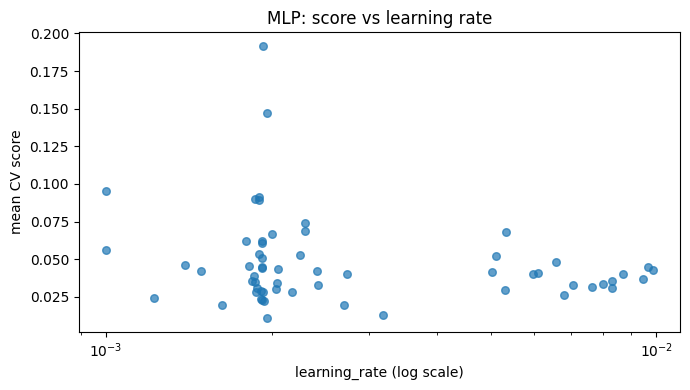

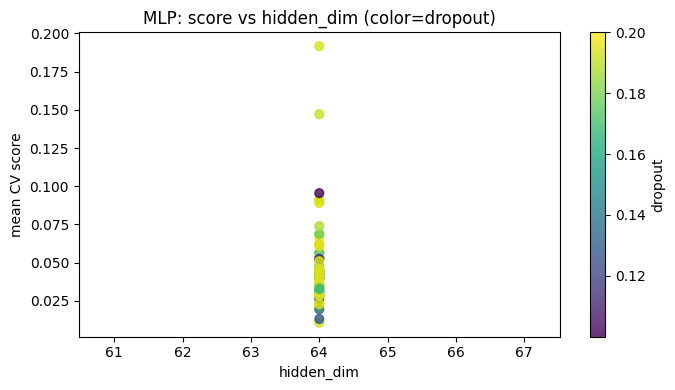

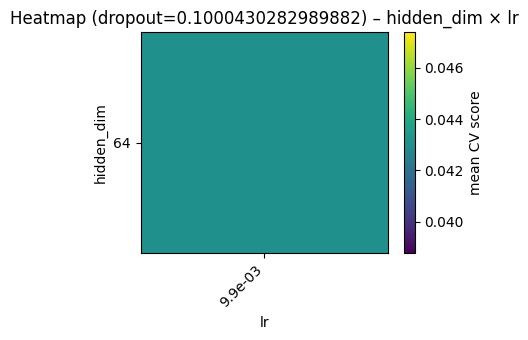

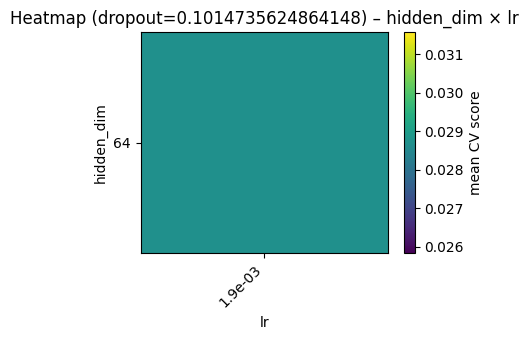

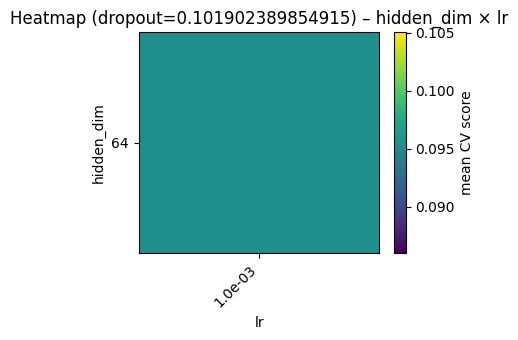

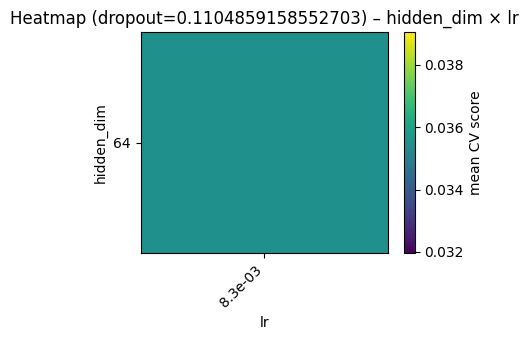

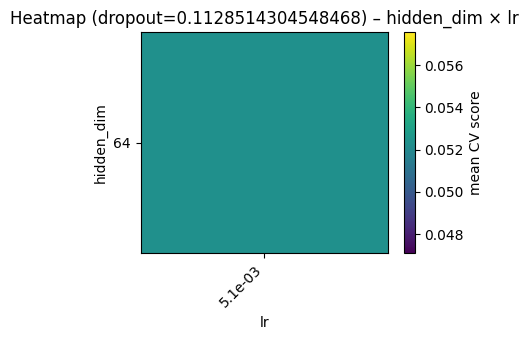

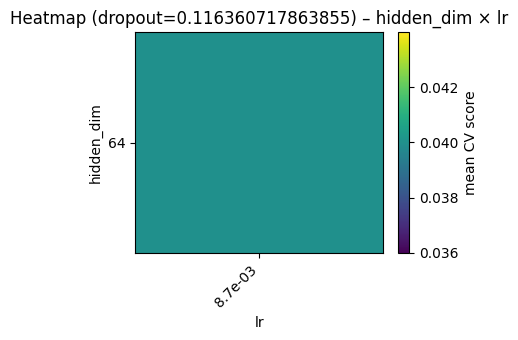

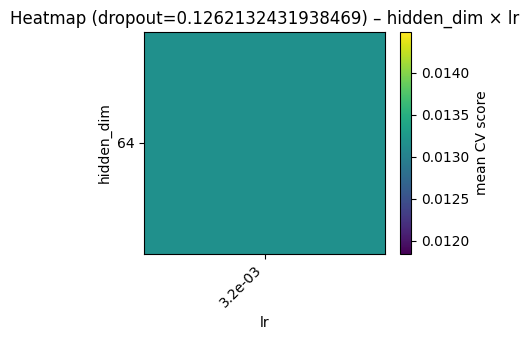

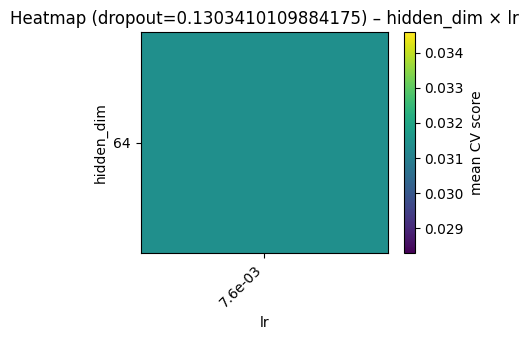

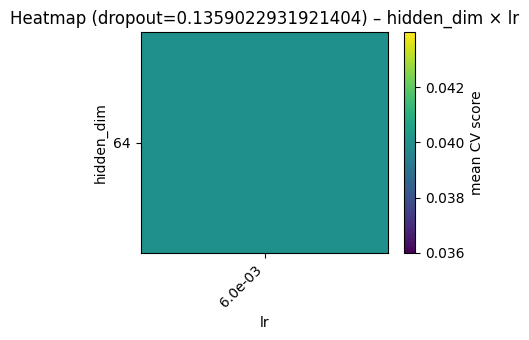

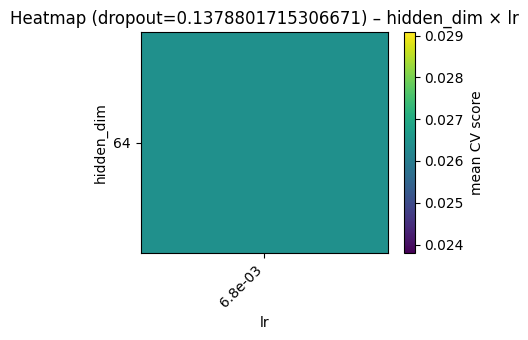

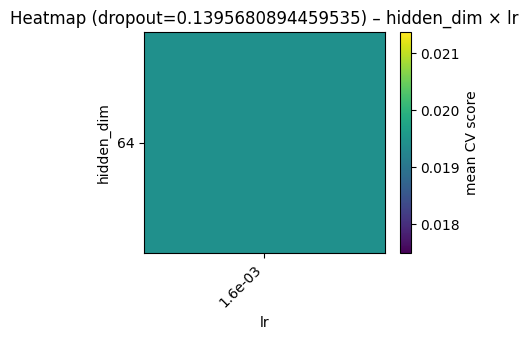

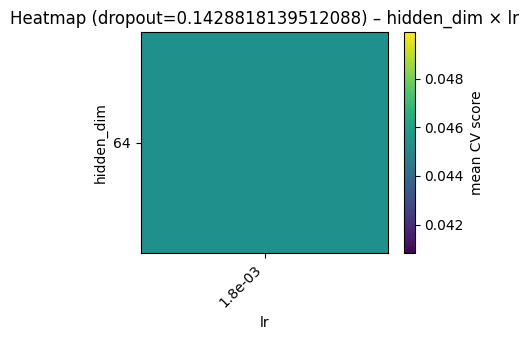

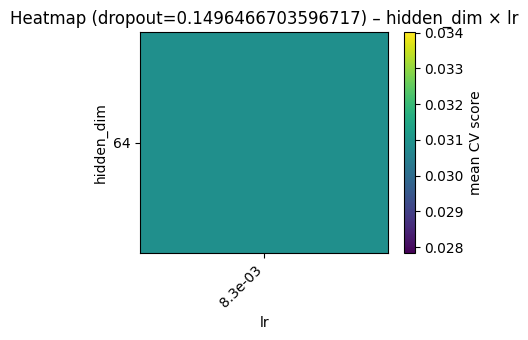

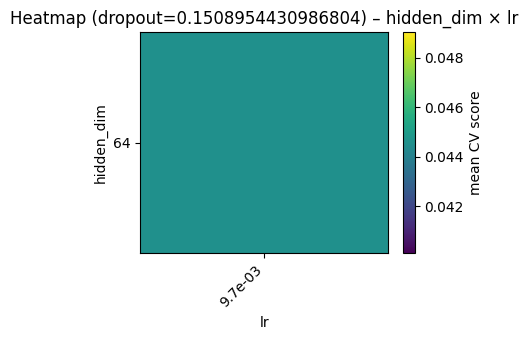

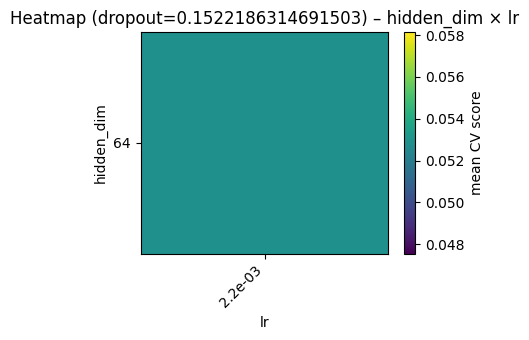

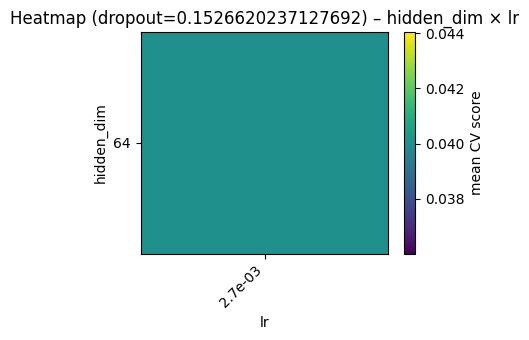

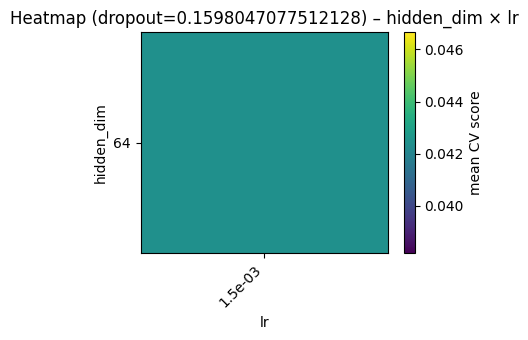

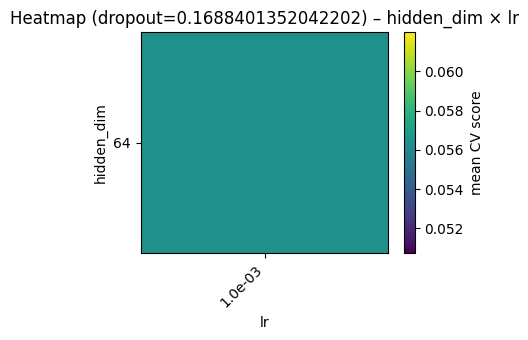

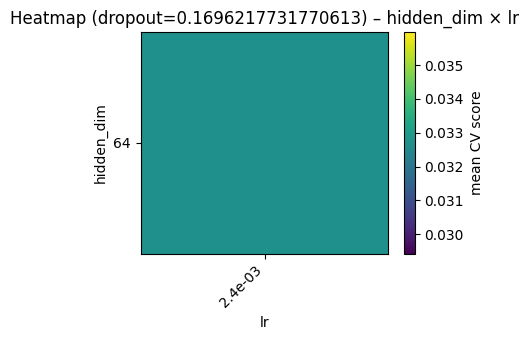

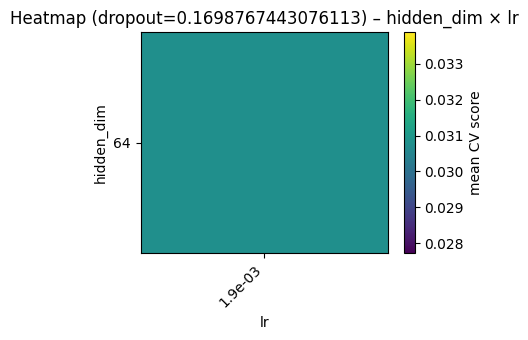

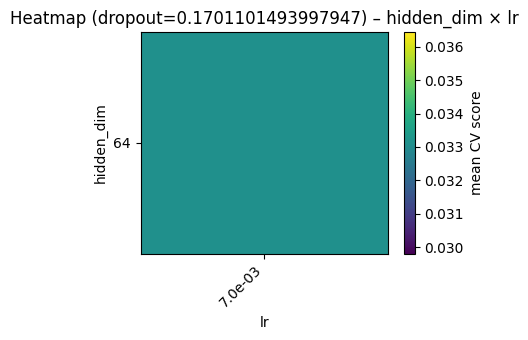

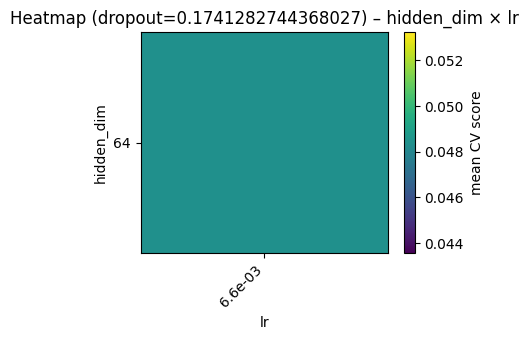

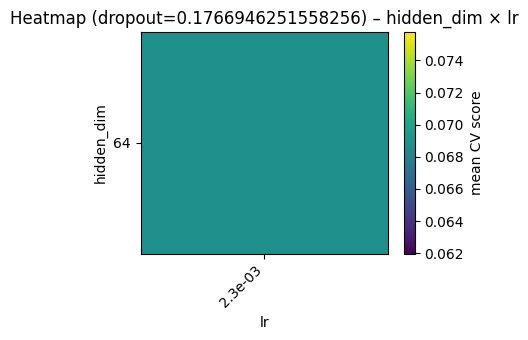

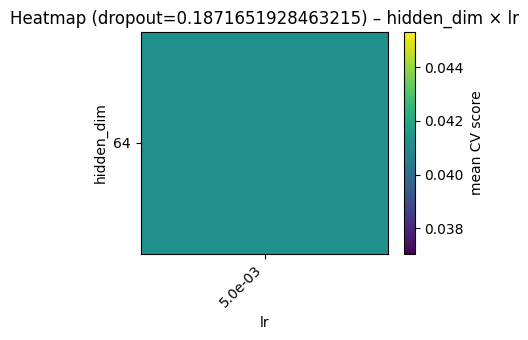

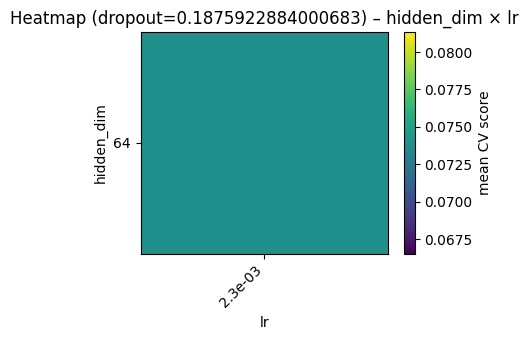

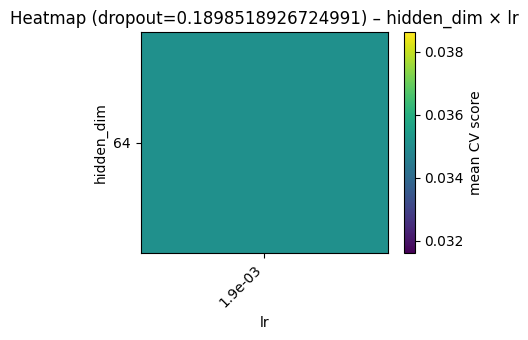

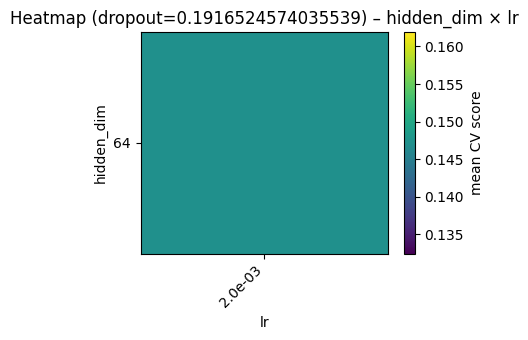

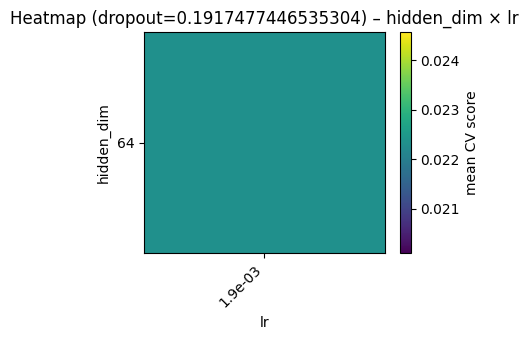

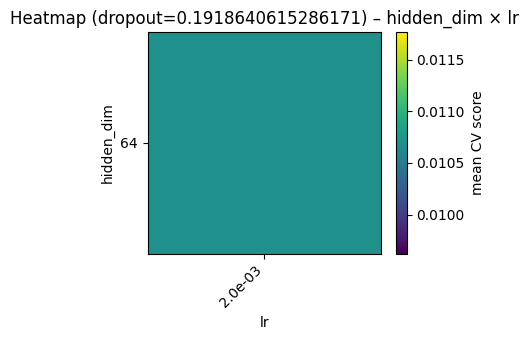

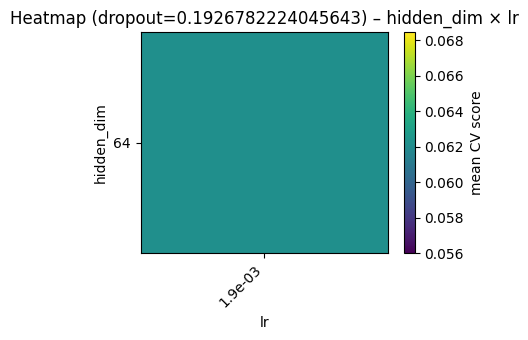

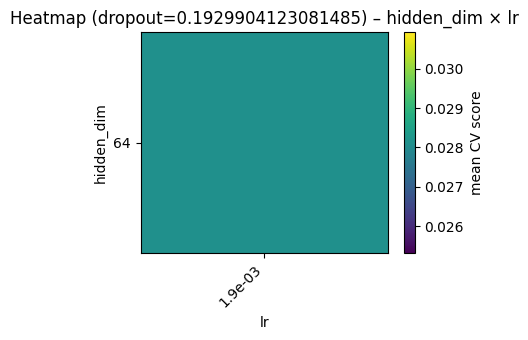

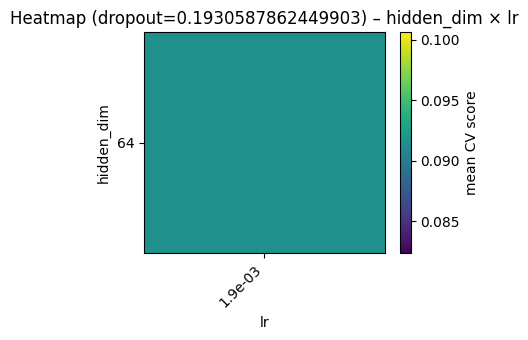

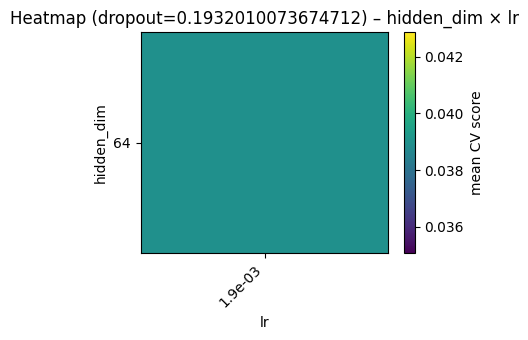

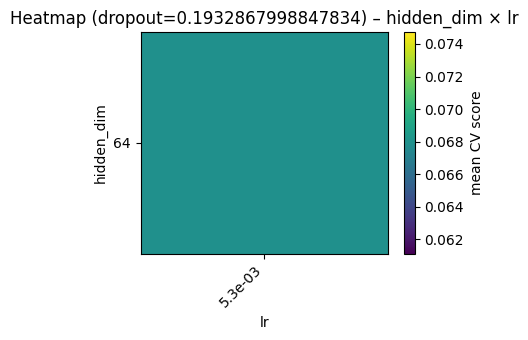

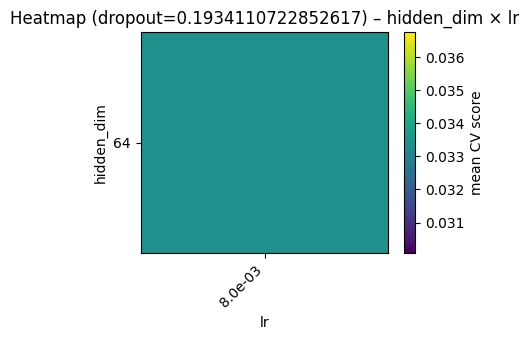

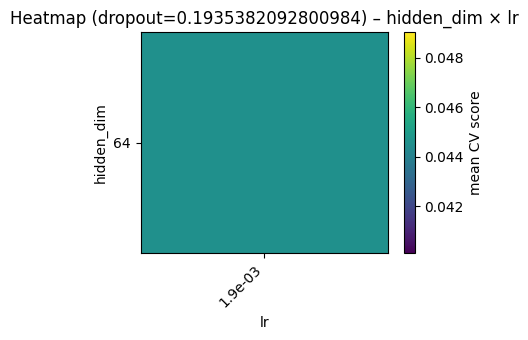

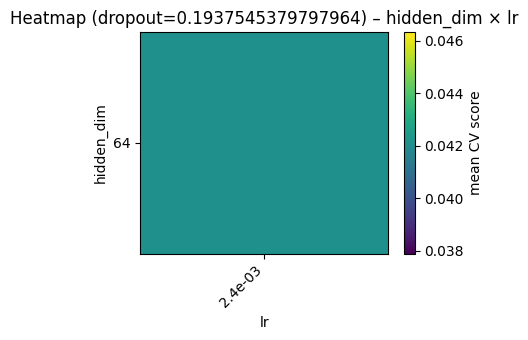

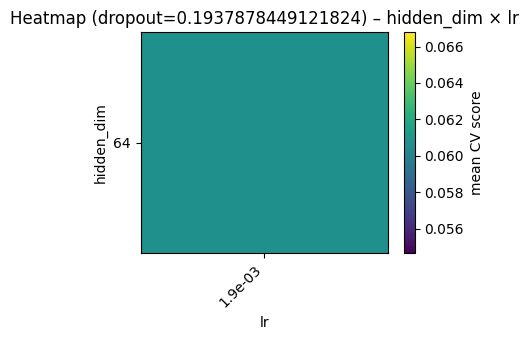

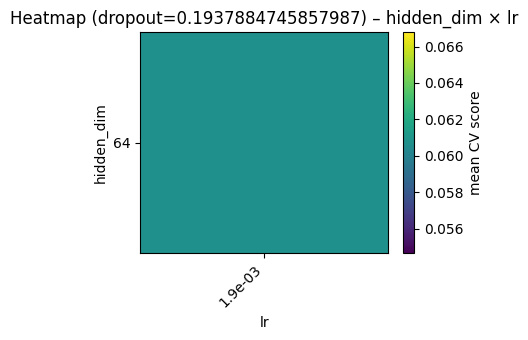

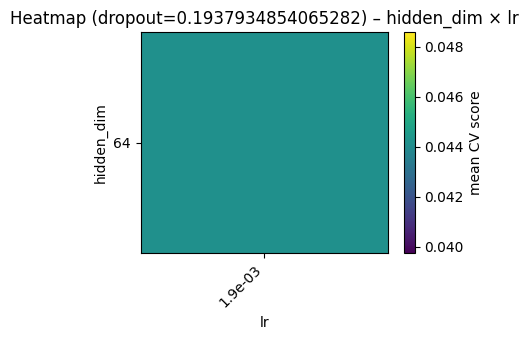

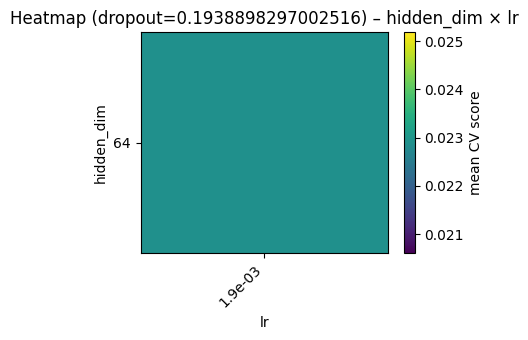

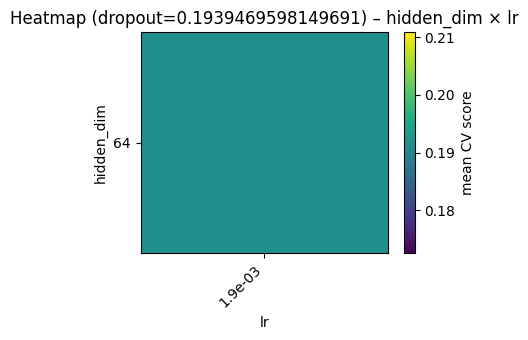

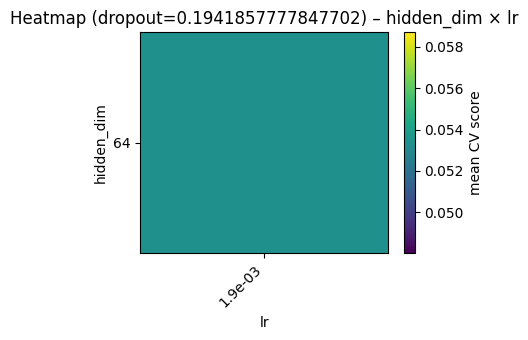

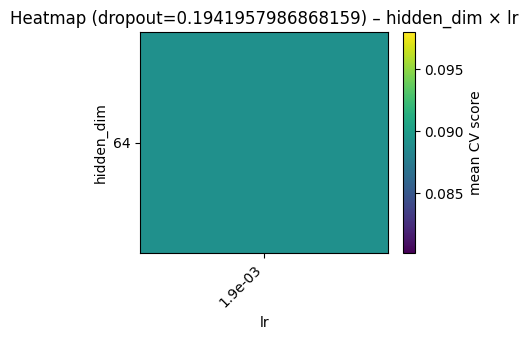

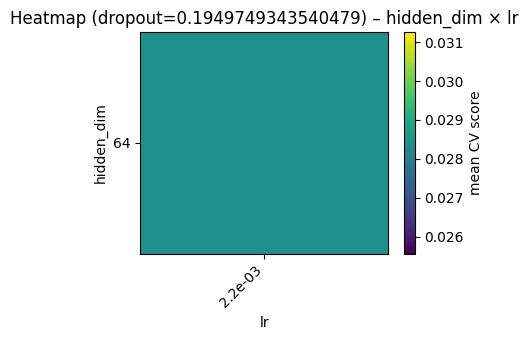

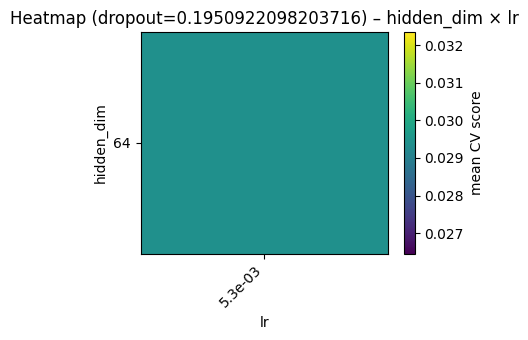

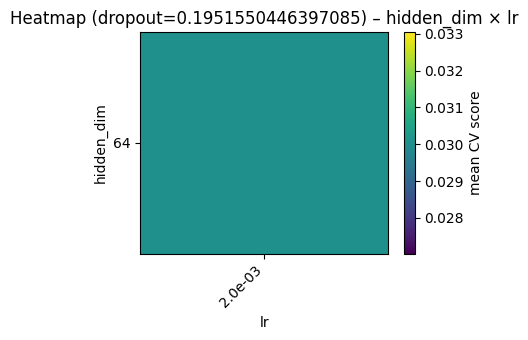

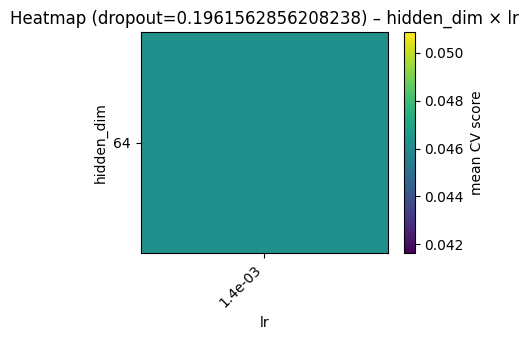

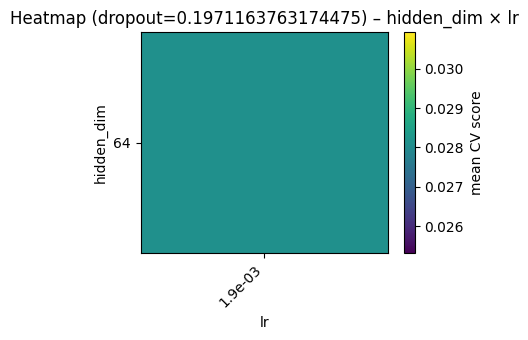

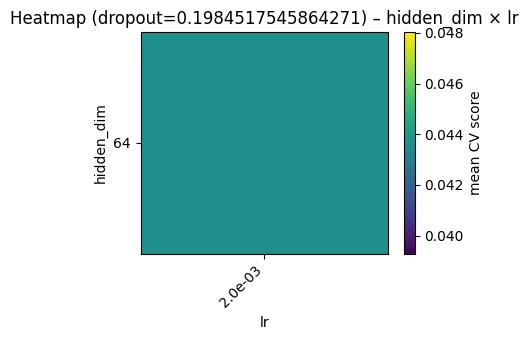

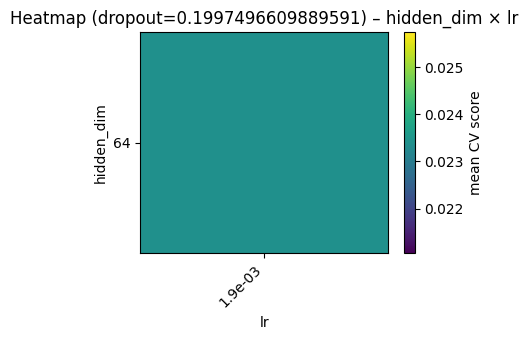

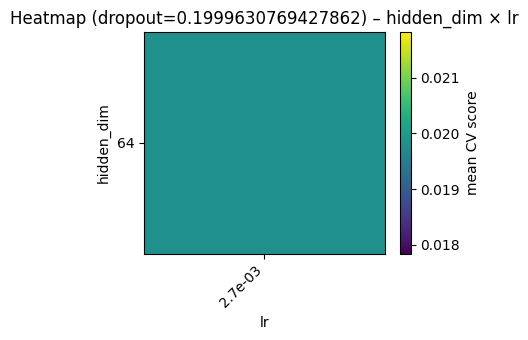

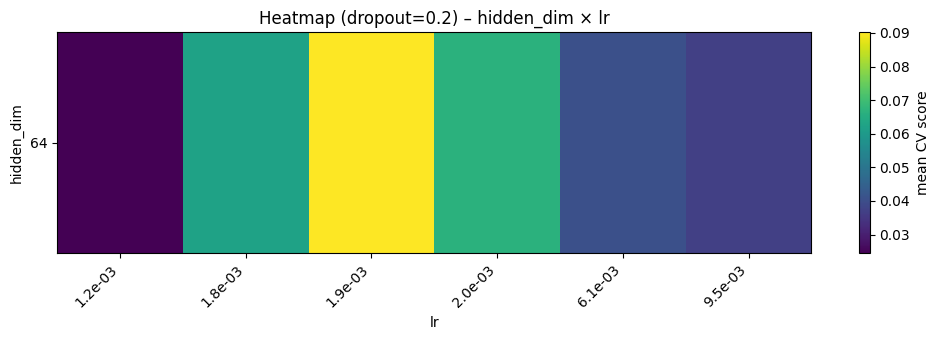

C:\Users\Kadri.Mufti\AppData\Local\Temp\ipykernel_123412\3209968099.py:100: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


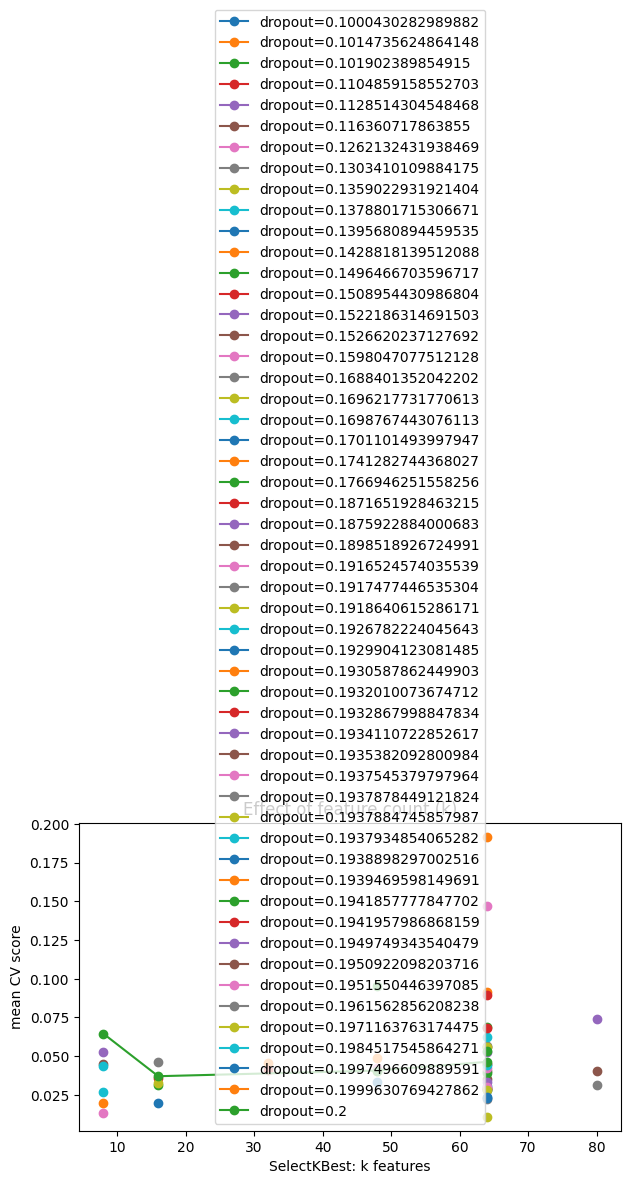

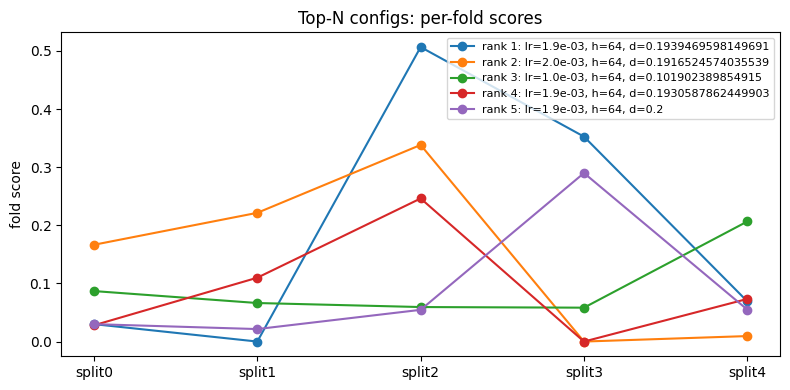

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from pathlib import Path

# ---------- Load ----------
path = Path("models/MLP_GPU/cv_results.csv")
df = pd.read_csv(path)

# If you logged multiple models in one file, optionally filter rows here
# e.g., df = df[df['estimator_name'] == 'MLP_torch']  # adjust if you have such a column

# ---------- Coerce types ----------
num_cols = [
    "mean_fit_time","std_fit_time","mean_score_time","std_score_time",
    "param_model__batch_size","param_model__lr","param_model__module__dropout",
    "param_model__module__hidden_dim","param_select__k",
    "split0_test_score","split1_test_score","split2_test_score","split3_test_score","split4_test_score",
    "mean_test_score","std_test_score","rank_test_score"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop rows with missing essential params
essential = ["param_model__lr","param_model__module__hidden_dim","param_model__module__dropout","mean_test_score"]
df = df.dropna(subset=[c for c in essential if c in df.columns]).copy()

# ---------- Quick text summary ----------
top = df.sort_values("mean_test_score", ascending=False).head(5)
worst = df.sort_values("mean_test_score", ascending=True).head(5)
print("\n=== Top 5 configs ===")
print(top[["mean_test_score","std_test_score","param_model__lr","param_model__module__hidden_dim",
           "param_model__module__dropout","param_model__batch_size","param_select__k"]])
print("\n=== Worst 5 configs ===")
print(worst[["mean_test_score","std_test_score","param_model__lr","param_model__module__hidden_dim",
             "param_model__module__dropout","param_model__batch_size","param_select__k"]])

# ---------- 1) Score vs. learning rate ----------
plt.figure(figsize=(7,4))
plt.scatter(df["param_model__lr"], df["mean_test_score"], s=30, alpha=0.7)
plt.xscale("log")
plt.xlabel("learning_rate (log scale)")
plt.ylabel("mean CV score")
plt.title("MLP: score vs learning rate")
plt.tight_layout(); plt.show()

# ---------- 2) Score vs. hidden dim (optionally colored by dropout) ----------
if "param_model__module__dropout" in df.columns:
    cvals = df["param_model__module__dropout"]
else:
    cvals = None

plt.figure(figsize=(7,4))
sc = plt.scatter(df["param_model__module__hidden_dim"], df["mean_test_score"], c=cvals, cmap="viridis", s=40, alpha=0.8)
plt.xlabel("hidden_dim")
plt.ylabel("mean CV score")
plt.title("MLP: score vs hidden_dim (color=dropout)")
if cvals is not None:
    cb = plt.colorbar(sc); cb.set_label("dropout")
plt.tight_layout(); plt.show()

# ---------- 3) Heatmaps per dropout: hidden_dim x lr ----------
def heat_for_dropout(drp, data, max_cols=6, max_rows=6):
    sub = data[np.isclose(data["param_model__module__dropout"], drp)]
    if sub.empty: 
        return
    # Discretize lr for pivot readability
    sub = sub.copy()
    sub["lr_str"] = sub["param_model__lr"].map(lambda x: f"{x:.1e}")
    piv = sub.pivot_table(index="param_model__module__hidden_dim", columns="lr_str", values="mean_test_score", aggfunc="max")
    # limit size
    piv = piv.iloc[:max_rows, :max_cols]
    plt.figure(figsize=(1.2*len(piv.columns)+3, 0.5*len(piv.index)+3))
    plt.imshow(piv.values, aspect="auto", cmap="viridis")
    plt.xticks(range(len(piv.columns)), piv.columns, rotation=45, ha="right")
    plt.yticks(range(len(piv.index)), piv.index)
    plt.colorbar(label="mean CV score")
    plt.title(f"Heatmap (dropout={drp}) – hidden_dim × lr")
    plt.xlabel("lr"); plt.ylabel("hidden_dim")
    plt.tight_layout(); plt.show()

if "param_model__module__dropout" in df.columns:
    for dr in sorted(df["param_model__module__dropout"].dropna().unique()):
        heat_for_dropout(dr, df)

# ---------- 4) Effect of SelectKBest (k) ----------
if "param_select__k" in df.columns:
    plt.figure(figsize=(7,4))
    for dr in sorted(df["param_model__module__dropout"].dropna().unique()) if "param_model__module__dropout" in df.columns else [None]:
        sub = df if dr is None else df[np.isclose(df["param_model__module__dropout"], dr)]
        grp = sub.groupby("param_select__k")["mean_test_score"].mean()
        plt.plot(grp.index, grp.values, marker="o", label=f"dropout={dr}" if dr is not None else "all")
    plt.xlabel("SelectKBest: k features")
    plt.ylabel("mean CV score")
    plt.title("Effect of feature count (k)")
    if "param_model__module__dropout" in df.columns:
        plt.legend()
    plt.tight_layout(); plt.show()

# ---------- 5) Stability across folds for top-N configs ----------
N = 5
bestN = df.sort_values("mean_test_score", ascending=False).head(N).copy()
fold_cols = [c for c in df.columns if c.startswith("split") and c.endswith("_test_score")]
plt.figure(figsize=(max(8, 1.6*N), 4))
for i, (_, row) in enumerate(bestN.iterrows(), 1):
    scores = [row[c] for c in fold_cols if pd.notnull(row[c])]
    plt.plot(range(len(scores)), scores, marker="o", label=f"rank {int(row['rank_test_score'])}: lr={row['param_model__lr']:.1e}, h={int(row['param_model__module__hidden_dim'])}, d={row['param_model__module__dropout']}")
plt.xticks(range(len(fold_cols)), [c.split('_')[0] for c in fold_cols])
plt.ylabel("fold score")
plt.title("Top-N configs: per-fold scores")
plt.legend(fontsize=8, loc="best")
plt.tight_layout(); plt.show()
